#data set link :https://drive.google.com/drive/folders/1X7FGBuxx2405tv64OnxebB3fLq--5Ada?usp=sharing

#Matrix factorization

In [ ]:
#library imports
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from scipy import sparse
#import jovian

In [ ]:
movie_ratings_df = pd.read_csv("/content/ratings.csv")
movie_ratings_df.shape
print(movie_ratings_df.head())

   userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0


In [ ]:
#checking for null values
movie_ratings_df.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [ ]:
#calculating number of each rating
Counter(movie_ratings_df.rating)

Counter({0.5: 1370,
         1.0: 2811,
         1.5: 1791,
         2.0: 7551,
         2.5: 5550,
         3.0: 20047,
         3.5: 13136,
         4.0: 26818,
         4.5: 8551,
         5.0: 13211})

In [ ]:
#distribution of userid with movies
movie_ratings_df.groupby(['userId']).count()['movieId']


userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: movieId, Length: 610, dtype: int64

In [ ]:
#Average number of ratings per user
np.mean(movie_ratings_df.groupby(['userId']).count()['movieId'])

165.30491803278687

In [ ]:
train_df, valid_df = train_test_split(movie_ratings_df, test_size=0.2)

#resetting indices to avoid indexing errors in the future
train_df = train_df.reset_index()[['userId', 'movieId', 'rating']]
valid_df = valid_df.reset_index()[['userId', 'movieId', 'rating']]

In [ ]:
userId = np.array(movie_ratings_df['userId'])
movieId = np.array(movie_ratings_df['movieId'])

#Preprocessing

we need continuous IDs to be able to index into the embedding matrix and access each user/item embedding.

In [ ]:
def encode_column(column):
    """ Encodes a pandas column with continous IDs"""
    keys = column.unique()
    key_to_id = {key:idx for idx,key in enumerate(keys)}
    return key_to_id, np.array([key_to_id[x] for x in column]), len(keys)

In [ ]:
def encode_df(movie_df):
    """Encodes rating data with continuous user and movie ids"""
    
    movieIds, movie_df['movieId'], num_movie = encode_column(movie_df['movieId'])
    userIds, movie_df['userId'], num_users = encode_column(movie_df['userId'])
    return movie_df, num_users, num_movie, userIds, movieIds

In [ ]:
movie_df, num_users, num_movie, userIds, movieIds = encode_df(train_df)
print("Number of users :", num_users)
print("Number of movie :", num_movie)
movie_df.head()

Number of users : 610
Number of movie : 8998


,userId,movieId,rating
0,0,0,5.0
1,1,1,3.0
2,2,2,3.0
3,3,3,3.5
4,4,4,2.0


#Training
Our goal is to find the optimal embeddings for each user and each item.

Initializing user and item embeddings

In [ ]:
def create_embeddings(n, K):
    """
    Creates a random numpy matrix of shape n, K with uniform values in (0, 11/K)
    n: number of items/users
    K: number of factors in the embedding 
    """
    return 11*np.random.random((n, K)) / K

Creating Sparse utility matrix

In [ ]:
def create_sparse_matrix(df, rows, cols, column_name="rating"):
  return sparse.csc_matrix((df[column_name].values,(df['userId'].values, df['movieId'].values)),shape=(rows, cols))

In [ ]:
movie_df, num_users, num_movie, userIds, movieIds = encode_df(train_df)
Y = create_sparse_matrix(movie_df, num_users, num_movie)
# to view matrix
Y.todense()

matrix([[5., 0., 0., ..., 0., 0., 0.],
        [0., 3., 0., ..., 0., 0., 0.],
        [0., 0., 3., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Making predictions

In [ ]:
def predict(df, emb_user, emb_movie):
    """ This function computes df["prediction"] without doing (U*V^T).
    
    Computes df["prediction"] by using elementwise multiplication of the corresponding embeddings and then 
    sum to get the prediction u_i*v_j. This avoids creating the dense matrix U*V^T.
    """
    df['prediction'] = np.sum(np.multiply(emb_movie[df['movieId']],emb_user[df['userId']]), axis=1)
    return df

Cost function: We are trying to minimize the Mean squared error over the utility matrix. 

In [ ]:
lmbda = 0.0001

In [ ]:
def cost(df, emb_user, emb_movie):
    """ Computes mean square error"""
    Y = create_sparse_matrix(df, emb_user.shape[0], emb_movie.shape[0])
    predicted = create_sparse_matrix(predict(df, emb_user, emb_movie), emb_user.shape[0], emb_movie.shape[0], 'prediction')
    return np.sum((Y-predicted).power(2))/df.shape[0] 

Gradient Descent

In [ ]:
def gradient(df, emb_user, emb_movie):
    """ Computes the gradient for user and movie embeddings"""
    Y = create_sparse_matrix(df, emb_user.shape[0], emb_movie.shape[0])
    predicted = create_sparse_matrix(predict(df, emb_user, emb_movie), emb_user.shape[0], emb_movie.shape[0], 'prediction')
    delta =(Y-predicted)
    grad_user = (-2/df.shape[0])*(delta*emb_movie) + 2*lmbda*emb_user
    grad_movie = (-2/df.shape[0])*(delta.T*emb_user) + 2*lmbda*emb_movie
    return grad_user, grad_movie

In [ ]:
def gradient_descent(df, emb_user, emb_movie, iterations=2000, learning_rate=0.001, df_val=None):
    """ 
    Computes gradient descent with momentum (0.9) for given number of iterations.
    emb_user: the trained user embedding
    emb_movie: the trained movie embedding
    """
    Y = create_sparse_matrix(df, emb_user.shape[0], emb_movie.shape[0])
    beta = 0.9
    grad_user, grad_movie = gradient(df, emb_user, emb_movie)
    v_user = grad_user
    v_movie = grad_movie
    for i in range(iterations):
        grad_user, grad_movie = gradient(df, emb_user, emb_movie)
        v_user = beta*v_user + (1-beta)*grad_user
        v_movie = beta*v_movie + (1-beta)*grad_movie
        emb_user = emb_user - learning_rate*v_user
        emb_movie = emb_movie - learning_rate*v_movie
        if(not (i+1)%50):
            print("\niteration", i+1, ":")
            print("train mse:",  cost(df, emb_user, emb_movie))
            if df_val is not None:
                print("validation mse:",  cost(df_val, emb_user, emb_movie))
    return emb_user, emb_movie

In [ ]:
emb_user = create_embeddings(num_users, 3)
emb_movie = create_embeddings(num_movie, 3)
emb_user, emb_movie = gradient_descent(movie_df, emb_user, emb_movie, iterations=800, learning_rate=1)


iteration 50 :
train mse: 5.022269806729269

iteration 100 :
train mse: 3.255948600694187

iteration 150 :
train mse: 2.615870198067016

iteration 200 :
train mse: 2.2467773069258974

iteration 250 :
train mse: 2.0020542811584296

iteration 300 :
train mse: 1.82588411668126

iteration 350 :
train mse: 1.6919939427577781

iteration 400 :
train mse: 1.5863039913726842

iteration 450 :
train mse: 1.500527734782006

iteration 500 :
train mse: 1.4294218896512407

iteration 550 :
train mse: 1.369473475233894

iteration 600 :
train mse: 1.3182204079710418

iteration 650 :
train mse: 1.2738754760541238

iteration 700 :
train mse: 1.2351055061819118

iteration 750 :
train mse: 1.200894601121114

iteration 800 :
train mse: 1.1704553861084963


Making predictions on new data

In [ ]:
def encode_new_data(valid_df, userIds, movieIds):
    """ Encodes valid_df with the same encoding as train_df.
    """
    df_val_chosen = valid_df['movieId'].isin(movieIds.keys()) & valid_df['userId'].isin(userIds.keys())
    valid_df = valid_df[df_val_chosen]
    valid_df['movieId'] =  np.array([movieIds[x] for x in valid_df['movieId']])
    valid_df['userId'] = np.array([userIds[x] for x in valid_df['userId']])
    return valid_df

In [ ]:
print("before encoding:", valid_df.shape)
valid_df = encode_new_data(valid_df, userIds, movieIds)
print("after encoding:", valid_df.shape)

before encoding: (20168, 3)
after encoding: (15501, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
train_mse = cost(train_df, emb_user, emb_movie)
val_mse = cost(valid_df, emb_user, emb_movie)
print(train_mse, val_mse)

1.1704553861084963 2.674848826083774


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
#looking at the predictions
valid_df[1:10].head()

,userId,movieId,rating,prediction
2,74,6787,5.0,3.980296
5,474,41,3.5,2.631385
6,240,519,3.0,2.489681
8,600,4975,3.5,2.579600
9,249,2231,3.5,3.746887


In [ ]:
  predicted_ratings = np.array(valid_df[['prediction']])
  true_ratings = np.array(valid_df[['rating']])

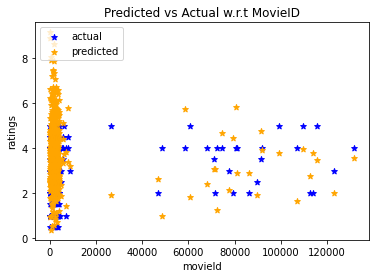

In [ ]:
# importing the required module
import matplotlib.pyplot as plt

plt.scatter(movieId[:500],true_ratings[:500],label= "stars", color= "blue", marker= "*")
plt.scatter(movieId[:500],predicted_ratings[:500],label= "stars", color= "orange", marker= "*")
plt.title('Predicted vs Actual w.r.t MovieID')
plt.ylabel('ratings')
plt.xlabel('movieId')
plt.legend(['actual', 'predicted'], loc='upper left')
plt.show()

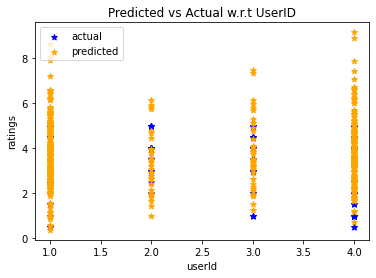

In [ ]:
plt.scatter(userId[:500],true_ratings[:500],label= "stars", color= "blue", marker= "*")
plt.scatter(userId[:500],predicted_ratings[:500],label= "stars", color= "orange", marker= "*")
plt.title('Predicted vs Actual w.r.t UserID')
plt.ylabel('ratings')
plt.xlabel('userId')
plt.legend(['actual', 'predicted'], loc='upper left')
plt.show()

In [ ]:
#evaluates on test set
from sklearn.metrics import mean_squared_error
def score_on_test_set():
#user_movie_pairs = zip(valid_df[‘movieId’], valid_df[‘userId’])
  predicted_ratings = np.array(valid_df[['prediction']])
  true_ratings = np.array(valid_df[['rating']])
  score = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
  return score
test_set_score = score_on_test_set()
print(test_set_score)

1.635496507511946


 Common latent factor techniques compute a low-rank rating matrix by applying Singular Value Decomposition through gradient descent
or Regularized Alternating Least Square algorithm

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

--2021-12-02 09:01:11--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.1’

ml-1m.zip.1         100%[===================>]   5.64M  27.6MB/s    in 0.2s    

2021-12-02 09:01:12 (27.6 MB/s) - ‘ml-1m.zip.1’ saved [5917549/5917549]



In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip

--2021-12-02 08:58:42--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  22.3MB/s    in 0.2s    

2021-12-02 08:58:42 (22.3 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [ ]:
!unzip ml-1m.zip

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [ ]:
!unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


#User-Based Collaborative Filtering

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
dataset = pd.read_csv('ml-100k/u.data', delimiter = '\t',names=['user_id','item_id','rating','timestamp'])
dataset.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Transforming data into the matrix

In [ ]:
n_users = dataset.user_id.unique().shape[0]
n_items = dataset.item_id.unique().shape[0]
n_items = dataset['item_id'].max()
A = np.zeros((n_users,n_items))
for line in dataset.itertuples():
    A[line[1]-1,line[2]-1] = line[3]
print("Original rating matrix : ",A)

Original rating matrix :  [[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]


converts the MovieLens dataset into the binary MovieLens dataset. We have considered items whose ratings are greater or equal to 3 being liked by the user and others being disliked by the user.

In [ ]:
for i in range(len(A)):
  for j in range(len(A[0])):
    if A[i][j]>=3:
      A[i][j]=1
    else:
      A[i][j]=0

we convert the dense rating matrix into a sparse matrix using the csr_matrix() function.

In [ ]:
csr_sample = csr_matrix(A)
print(csr_sample)

  (0, 0)	1.0
  (0, 1)	1.0
  (0, 2)	1.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 5)	1.0
  (0, 6)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (0, 11)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (0, 14)	1.0
  (0, 15)	1.0
  (0, 16)	1.0
  (0, 17)	1.0
  (0, 18)	1.0
  (0, 19)	1.0
  (0, 21)	1.0
  (0, 22)	1.0
  (0, 23)	1.0
  (0, 24)	1.0
  (0, 25)	1.0
  (0, 27)	1.0
  (0, 29)	1.0
  :	:
  (942, 624)	1.0
  (942, 654)	1.0
  (942, 671)	1.0
  (942, 684)	1.0
  (942, 716)	1.0
  (942, 720)	1.0
  (942, 721)	1.0
  (942, 731)	1.0
  (942, 738)	1.0
  (942, 762)	1.0
  (942, 764)	1.0
  (942, 793)	1.0
  (942, 795)	1.0
  (942, 807)	1.0
  (942, 815)	1.0
  (942, 823)	1.0
  (942, 824)	1.0
  (942, 839)	1.0
  (942, 927)	1.0
  (942, 942)	1.0
  (942, 1043)	1.0
  (942, 1073)	1.0
  (942, 1187)	1.0
  (942, 1227)	1.0
  (942, 1329)	1.0


Compute similarity between items of csr_sample using cosine similarity

In [ ]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=3, n_jobs=-1)
knn.fit(csr_sample)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=3)

generate recommendations for user_id:1 based on 20 items being liked by him

In [ ]:
dataset_sort_des = dataset.sort_values(['user_id', 'timestamp'], ascending=[True, False])
filter1 = dataset_sort_des[dataset_sort_des['user_id'] == 1].item_id
filter1 = filter1.tolist()
filter1 = filter1[:20]
print("Items liked by user: ",filter1)

Items liked by user:  [74, 102, 256, 5, 171, 111, 242, 189, 32, 209, 270, 18, 6, 244, 221, 129, 20, 271, 272, 255]


Next, for each item being liked by the user1, we recommend 2 similar items

In [ ]:
distances1=[]
indices1=[]
for i in filter1:
  distances , indices = knn.kneighbors(csr_sample[i],n_neighbors=3)
  indices = indices.flatten()
  indices= indices[1:]
  indices1.extend(indices)
print("Items to be recommended: ",indices1)

Items to be recommended:  [356, 500, 758, 512, 883, 893, 473, 17, 311, 566, 771, 283, 614, 105, 904, 163, 510, 501, 642, 406, 473, 17, 578, 475, 312, 845, 688, 778, 681, 550, 275, 879, 365, 371, 685, 928, 719, 283, 373, 331]


This is to create a repos for movie rating prediction. It covers 3 use cases.

Predict user rating from 0 to 5 by creating a stacked auto-encoder netowrk.

Predict user likes or not by creating a restricted Boltzmann machine.

use Pearson correlation matrix and create an item-based movie recommender.

#Stacked_Autoencoder_Rating_Prediction.

In [ ]:
# AutoEncoders

# Importing the libraries
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable


In [ ]:
# Importing the dataset
movies = pd.read_csv('ml-1m/movies.dat', sep = '::', names=['title','genres'], engine = 'python', encoding = 'latin-1')
users = pd.read_csv('ml-1m/users.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
ratings = pd.read_csv('ml-1m/ratings.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')

In [ ]:
movies.head()

,title,genres
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


In [ ]:
users.head()

,0,1,2,3,4
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [ ]:
ratings.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
##create training and test set data
# here only take u1.base but there are another u2 u3 u4 u5 base files
training_set = pd.read_csv('ml-100k/u1.base', delimiter = '\t', header = None)
print(training_set.head(3))

   0  1  2          3
0  1  1  5  874965758
1  1  2  3  876893171
2  1  3  4  878542960


we convert Dataframe to Numpy array because we will use Pytorch tensor which requires array as input. 

In [ ]:
##convert it to array
training_set = np.array(training_set, dtype = 'int')

In [ ]:
training_set.shape

(80000, 4)

In [ ]:
test_set = pd.read_csv('ml-100k/u1.test', delimiter = '\t', header = None)
##convert it to array
test_set = np.array(test_set, dtype = 'int')
test_set.shape

(20000, 4)

Data structure creation

To prepare the training/test data, we need to create training/test sets in array format with each row representing a user and each cell in the row representing the rating for each movie. This is the expected input for auto-encoder.

In [ ]:
#take max users id in train and test data
nb_users = int(max(max(training_set[:,0]), max(test_set[:,0])))
nb_movies = int(max(max(training_set[:,1]), max(test_set[:,1])))
print('Num of users: ', nb_users, '\nNum of movies: ', nb_movies)

Num of users:  943 
Num of movies:  1682


We create a function for data conversion which returns a list of lists. Each child list represents one user’s ratings for all movies. If the user did not rate a movie, initialize the rating with 0. 

In [ ]:
def convert(data):
    new_data = []
    for id_users in range(1, nb_users + 1):
        ##id of movies that is rated by current users
        id_movies = data[:,1][data[:,0] == id_users]
        
        ##rate of movies that is given by current user
        id_ratings = data[:,2][data[:,0] == id_users]
        
        #inialize ratings for all movies
        #set 0 for movies that are not rated by current users
        ratings = np.zeros(nb_movies)
        #movie id starts from 1, 1st movie will be 1st element in rating with index as 0
        ratings[id_movies - 1] = id_ratings
        new_data.append(list(ratings))
    return new_data

With the above conversion function, we convert the training set and test set.

In [ ]:
training_set = convert(training_set)
test_set = convert(test_set)

convert data into Torch tensor because we will use Pytorch to build the auto-encoder.

In [ ]:
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

In [ ]:
training_set

tensor([[5., 3., 4.,  ..., 0., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [5., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 0.]])

In [ ]:
test_set

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

 SAE architecture creation

In [ ]:
class SAE(nn.Module):
    def __init__(self, ):
        #allow to inhert all classes and methods of parent class
        super(SAE, self).__init__()
        #num of features from input: num of movies, 20 nodes in first hidden layer
        self.fc1 = nn.Linear(nb_movies, 20)
        self.fc2 = nn.Linear(20, 10)
        #start to decoding
        self.fc3 = nn.Linear(10, 20)
        self.fc4 = nn.Linear(20, nb_movies)
        self.activation = nn.Sigmoid()
        
    #input vector (movies rating) for a specific users
    def forward(self, x):
        #apply activaton fuc on first encoding layer
        #return first encoded vector
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        #no need to activate the vector
        #output the reconstrctured vector
        x = self.fc4(x)
        return x

 Model training

In [ ]:
sae = SAE()
#Create loss fucn object
criterion = nn.MSELoss()
#create optimizer object
#parameters of all auto-encoders defined in the class
optimizer = optim.RMSprop(sae.parameters(), lr = 0.01, weight_decay = 0.5)

In [ ]:
# #train the SAE using pytorch only codes

#loop all epochs
nb_epoch = 200
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    #exclude users who did not rate any movies
    #define a float
    s = 0.
    #loop through each users
    for id_user in range(nb_users):
        #get all rating for current user from training_set
        #nn does not take single dimension vector, so add a batch dimension
        #a batch of sinlge inptu vector, update weigths after each vector
        input = Variable(training_set[id_user]).unsqueeze(0)
        #create target by copying input
        target = input.clone()
        #only look at users who rated at least 1 movie
        if torch.sum(target.data > 0) > 0:
            #get output from the network, a vector of predicted value
            output = sae(input)
            #do not compute gradient with respect to target
            target.require_grad = False
            #don't account the output whose initial input is 0
            output[target == 0] = 0
            loss = criterion(output, target)
            #make demonitor is not zero, to add a small number
            mean_corrector = nb_movies / float(torch.sum(target.data>0) + 1e-10)
            #backward method to determine which direction 
            loss.backward()
            #access the data of loss object .data[0]
            #adjust the loss to compute relevant mean for all movies for current user
            train_loss += np.sqrt(loss.data * mean_corrector)
            s += 1.
            #apply optimizer to update weights, decides the amount of weight udpates
            optimizer.step()
    if epoch % 10 == 0:
        print('epoch: '+str(epoch) + ' loss: ' + str(train_loss/s))

epoch: 10 loss: tensor(1.0196)
epoch: 20 loss: tensor(1.0162)
epoch: 30 loss: tensor(1.0119)
epoch: 40 loss: tensor(0.9919)
epoch: 50 loss: tensor(0.9749)
epoch: 60 loss: tensor(0.9629)
epoch: 70 loss: tensor(0.9600)
epoch: 80 loss: tensor(0.9531)
epoch: 90 loss: tensor(0.9479)
epoch: 100 loss: tensor(0.9430)
epoch: 110 loss: tensor(0.9354)
epoch: 120 loss: tensor(0.9324)
epoch: 130 loss: tensor(0.9282)
epoch: 140 loss: tensor(0.9251)
epoch: 150 loss: tensor(0.9225)
epoch: 160 loss: tensor(0.9205)
epoch: 170 loss: tensor(0.9186)
epoch: 180 loss: tensor(0.9163)
epoch: 190 loss: tensor(0.9148)
epoch: 200 loss: tensor(0.9135)


 SAE testing

In [ ]:
#evaluation
#loop through each users
test_loss = 0
s = 0.
for id_user in range(nb_users):
    #keep using training set
    input = Variable(training_set[id_user]).unsqueeze(0)
    #create target by copying input
    target = Variable(test_set[id_user]).unsqueeze(0)
    #only look at users who rated at least 1 movie
    if torch.sum(target.data > 0) > 0:
        #get output from the network, a vector of predicted value
        output = sae(input)
        #do not compute gradient with respect to target
        target.require_grad = False
        #don't account the output whose initial input is 0
        output[target == 0] = 0
        loss = criterion(output, target)
        #make demonitor is not zero, to add a small number
        mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
        
        
        #access the data of loss object .data[0]
        #adjust the loss to compute relevant mean for all movies for current user
        test_loss += np.sqrt(loss.data*mean_corrector)
        s += 1.
print('test loss: '+str(test_loss/s))

test loss: tensor(0.9553)


Prediction

comparing the real ratings and the predicted ratings

In [ ]:
user_id = 0
movie_title = movies.iloc[:nb_movies, 0:1]
user_rating = training_set.data.numpy()[user_id, :].reshape(-1,1)
user_target = test_set.data.numpy()[user_id, :].reshape(-1,1)


In [ ]:
#to be predicted, target
user_target[user_target>0]

array([5., 3., 5., 5., 3., 4., 4., 3., 2., 3., 4., 2., 4., 5., 4., 3., 4.,
       3., 3., 4., 5., 4., 3., 5., 4., 3., 3., 3., 4., 3., 1., 4., 1., 4.,
       5., 5., 4., 3., 5., 4., 5., 3., 5., 3., 4., 5., 2., 1., 1., 4., 5.,
       1., 5., 5., 3., 3., 1., 4., 3., 4., 5., 3., 4., 4., 1., 1., 2., 2.,
       5., 4., 5., 2., 4., 3., 4., 4., 4., 3., 5., 5., 5., 5., 5., 3., 5.,
       4., 4., 4., 3., 3., 5., 4., 5., 3., 3., 5., 4., 5., 4., 4., 4., 2.,
       4., 3., 3., 1., 5., 4., 5., 2., 3., 4., 5., 4., 4., 3., 2., 5., 4.,
       4., 5., 1., 4., 4., 2., 5., 1., 2., 5., 1., 1., 3., 2., 4., 1., 4.,
       3.], dtype=float32)

In [ ]:
user_input = Variable(training_set[user_id]).unsqueeze(0)
# print('training input: ', len(training_set[user_id]), training_set[user_id])
predicted = sae(user_input)
predicted = np.round(predicted.data.numpy().reshape(-1,1), 2)
# print('predicted: \n', len(predicted), predicted)

In [ ]:
user_input = user_input.data.numpy().reshape(-1,1)
result_array = np.hstack([movie_title, user_input, user_target, predicted])
result_df = pd.DataFrame(data=result_array, columns=['Movie', 'User input', 'Target Rating', 'Predicted'])

In [ ]:
prediction = sae(test_set)
prediction

tensor([[3.7664, 3.2248, 2.7012,  ..., 1.9749, 3.2757, 2.9450],
        [4.5004, 4.3597, 4.0184,  ..., 2.5192, 4.1490, 3.7603],
        [4.7525, 4.7694, 4.5102,  ..., 2.7173, 4.4670, 4.0574],
        ...,
        [3.6088, 3.1396, 2.7055,  ..., 1.9415, 3.2180, 2.8945],
        [3.6088, 3.1396, 2.7055,  ..., 1.9415, 3.2180, 2.8945],
        [3.6088, 3.1396, 2.7055,  ..., 1.9415, 3.2180, 2.8945]],
       grad_fn=<AddmmBackward0>)

**The task is to predict if a user likes a movie as 1 or dislike as 0.**

 Binary data conversion
convert rating 1-5 to binary 1 or 0, as the target is to predict like or not
if not rated, set to 0
if rate is 1 or 2, set as 0 dislike
if rate is >= 3, set as 1 like

In [ ]:
##so this is to make input and output data consistent
training_set[training_set == 0] = -1
training_set[training_set == 1] = 0
training_set[training_set == 2] = 0
training_set[training_set >= 3] = 1

test_set[test_set == 0] = -1
test_set[test_set == 1] = 0
test_set[test_set == 2] = 0
test_set[test_set >= 3] = 1

In [ ]:
training_set

tensor([[ 1.,  1.,  1.,  ..., -1., -1., -1.],
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1.,  1., -1.,  ..., -1., -1., -1.]])

In [ ]:
test_set

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])

 RBM architecture creation

In [ ]:
class RBM():
    def __init__(self, nv, nh):
        ##initialize all weights 
        ##a tensor with size of nh, nv in normal dis mean 0 var 1
        self.W = torch.randn(nh, nv)
        #bias for hidden nodes
        #1st dimension is batch, 2nd is num of hidden nodes
        self.a = torch.randn(1, nh)
        #bias for visible nodes
        self.b = torch.randn(1, nv)
    #activate the hidden nodes by sampling all hiddens node, given values of visible nodes 
    def sample_h(self, x):
        #x is values of visible nodes
        #probablity of hiddens h to be activated, given values of visible  nodes v
        wx = torch.mm(x, self.W.t())
        #use sigmoid fuc to activate visible node
        ## a is bias for hidden nodes
        activation = wx + self.a.expand_as(wx)
        ##ith of the vector is the probability of ith hidden nodes to be activated, 
        ##given visible values
        p_h_given_v =torch.sigmoid(activation)
        #samples of all hiddens nodes
        return p_h_given_v, torch.bernoulli(p_h_given_v)
    def sample_v(self, y):
        #y is hidden nodes
        #probablity of visible h to be activated, given hidden  nodes v
        wy = torch.mm(y, self.W)
        #use sigmoid fuc to activate hiddens nodes
        activation = wy + self.b.expand_as(wy)
        ##ith of the vector is the probability of ith visible nodes to be activated, 
        ##given hidden values
        p_v_given_h =torch.sigmoid(activation)
        #samples of all hiddens nodes
        return p_v_given_h, torch.bernoulli(p_v_given_h)
        
    #visible nodes after kth interation
    #probablity of hidden nodes after kth iteration
    def train(self, v0, vk, ph0, phk):
#         self.W += torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)
        self.W += (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()
#         self.W += torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)
        #add zero to keep b as a tensor of 2 dimension
        self.b += torch.sum((v0 - vk), 0)
        self.a += torch.sum((ph0 - phk), 0)

Initialize RBM object

In [ ]:
#number of movies
nv = len(training_set[0])
#number of hidden nodes or num of features
nh = 100
batch_size = 100
rbm = RBM(nv, nh)

Model training

In [ ]:
nb_epoch = 10
for epoch in range(1, nb_epoch+1):
    ##loss function
    train_loss = 0
    #normalize the loss, define a counter
    s = 0.
    #implement a batch learning, 
    for id_user in range(0, nb_users - batch_size, 100):
        #input batch values
        vk = training_set[id_user: id_user+batch_size]
        #target used for loss mesarue: rating 
        v0 = training_set[id_user: id_user+batch_size]
        ##initilize probablity
        #pho: given real rating at begining, probablity of hidden nodes
        ph0, _ = rbm.sample_h(v0)
        #k step of constrative divergence
        for k in range(10):
            _, hk = rbm.sample_h(vk)
            _, vk = rbm.sample_v(hk)
            #training on rating that do exist, rating as -1
            vk[v0<0] = v0[v0<0]
        phk, _ = rbm.sample_h(vk)
        #update weights and bias
        rbm.train(v0, vk, ph0, phk)
        #update train loss
        train_loss += torch.mean(torch.abs(v0[v0>0]-vk[v0>0]))
        s += 1
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))

epoch: 1 loss: tensor(0.3118)
epoch: 2 loss: tensor(0.1540)
epoch: 3 loss: tensor(0.1498)
epoch: 4 loss: tensor(0.1533)
epoch: 5 loss: tensor(0.1486)
epoch: 6 loss: tensor(0.1505)
epoch: 7 loss: tensor(0.1585)
epoch: 8 loss: tensor(0.1362)
epoch: 9 loss: tensor(0.1466)
epoch: 10 loss: tensor(0.1468)


Test RBM

In [ ]:
##loss function
test_loss = 0
#normalize the loss, define a counter
s = 0.
#implement a batch learning, 
for id_user in range(0, nb_users):
    #use input of train set to activate RBM
    v_input = training_set[id_user: id_user+1]
    #target used for loss mesarue: rating 
    v_target = test_set[id_user: id_user+1]
    #use only 1 step to make better prediction, though used 10 steps to train
    if len(v_target[v_target>=0]):
        _, h = rbm.sample_h(v_input)
        _, v_input = rbm.sample_v(h)
        #update test loss
        test_loss += torch.mean(torch.abs(v_target[v_target>0]-v_input[v_target>0]))
        s += 1

In [ ]:
print('test loss: ' +str(test_loss/s))

test loss: tensor(0.1521)


Prediction

In [ ]:
prediction = sae(test_set)
prediction

tensor([[4.8630, 4.9375, 4.7070,  ..., 2.7982, 4.5971, 4.1789],
        [4.8599, 4.9335, 4.7028,  ..., 2.7963, 4.5941, 4.1761],
        [4.8598, 4.9335, 4.7027,  ..., 2.7963, 4.5940, 4.1761],
        ...,
        [4.8598, 4.9333, 4.7026,  ..., 2.7962, 4.5939, 4.1760],
        [4.8598, 4.9333, 4.7026,  ..., 2.7962, 4.5939, 4.1760],
        [4.8598, 4.9333, 4.7026,  ..., 2.7962, 4.5939, 4.1760]],
       grad_fn=<AddmmBackward0>)

In [ ]:
t=prediction.detach().numpy()
t

array([[4.862994 , 4.9375277, 4.7069936, ..., 2.7981968, 4.597098 ,
        4.178917 ],
       [4.8599215, 4.9335485, 4.702801 , ..., 2.7963388, 4.5940957,
        4.1761236],
       [4.859848 , 4.933453 , 4.702702 , ..., 2.7962945, 4.594024 ,
        4.176057 ],
       ...,
       [4.8597574, 4.9333315, 4.702571 , ..., 2.7962372, 4.5939317,
        4.1759706],
       [4.8597574, 4.9333315, 4.702571 , ..., 2.7962372, 4.5939317,
        4.1759706],
       [4.8597574, 4.9333315, 4.702571 , ..., 2.7962372, 4.5939326,
        4.1759706]], dtype=float32)

In [ ]:
df3=pd.DataFrame(t)
df3

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,4.862994,4.937528,4.706994,4.884969,4.724471,5.493420,4.676805,4.260369,3.736928,4.718725,5.127321,5.038467,3.287802,4.239405,5.117038,4.753840,5.064784,4.320230,5.626140,4.314803,3.973017,5.585716,4.794350,4.776856,4.655086,4.582791,4.656462,5.136333,3.975565,5.362119,5.269287,5.424236,4.915004,4.190876,3.538246,3.154755,3.521849,4.476736,4.805713,3.848466,...,5.376429,2.494873,6.242023,5.841465,4.655827,3.100961,4.646173,6.236533,6.245732,2.676255,6.569363,1.300108,2.793954,5.317999,4.308992,4.586832,1.286630,2.610664,1.348546,4.244437,2.945614,4.693539,2.950355,2.964138,4.420614,4.401104,2.940700,4.396425,1.373414,3.246153,3.552071,5.100080,3.694463,2.463468,4.607857,1.369591,4.147149,2.798197,4.597098,4.178917
1,4.859921,4.933548,4.702801,4.881745,4.720995,5.489340,4.674518,4.258825,3.736241,4.716664,5.124128,5.036795,3.287267,4.238099,5.114026,4.750484,5.060625,4.317459,5.622271,4.312119,3.970190,5.582136,4.792311,4.773793,4.652112,4.579904,4.652856,5.133636,3.972624,5.359056,5.265015,5.420805,4.911420,4.188023,3.535252,3.152486,3.519677,4.473520,4.802236,3.845858,...,5.372820,2.493190,6.237966,5.837593,4.652786,3.098937,4.643145,6.232471,6.241661,2.674235,6.564980,1.299243,2.792080,5.314195,4.306157,4.583652,1.285775,2.608912,1.347634,4.241521,2.943668,4.690333,2.948406,2.962174,4.417693,4.398197,2.938754,4.393523,1.372502,3.244016,3.549670,5.096644,3.691964,2.461805,4.604849,1.368682,4.144380,2.796339,4.594096,4.176124
2,4.859848,4.933453,4.702702,4.881670,4.720913,5.489244,4.674463,4.258789,3.736225,4.716615,5.124053,5.036755,3.287254,4.238068,5.113955,4.750403,5.060525,4.317393,5.622178,4.312055,3.970123,5.582051,4.792262,4.773721,4.652041,4.579835,4.652771,5.133572,3.972554,5.358983,5.264914,5.420722,4.911335,4.187955,3.535181,3.152431,3.519625,4.473444,4.802153,3.845796,...,5.372735,2.493150,6.237870,5.837501,4.652714,3.098889,4.643073,6.232375,6.241565,2.674188,6.564874,1.299222,2.792036,5.314104,4.306089,4.583576,1.285754,2.608870,1.347612,4.241452,2.943622,4.690257,2.948359,2.962126,4.417624,4.398128,2.938708,4.393454,1.372480,3.243964,3.549613,5.096560,3.691904,2.461766,4.604777,1.368661,4.144314,2.796294,4.594024,4.176057
3,4.859803,4.933394,4.702638,4.881620,4.720860,5.489182,4.674428,4.258766,3.736216,4.716584,5.124004,5.036730,3.287247,4.238049,5.113909,4.750352,5.060462,4.317351,5.622120,4.312015,3.970080,5.581997,4.792232,4.773674,4.651996,4.579791,4.652716,5.133530,3.972509,5.358936,5.264849,5.420671,4.911280,4.187912,3.535135,3.152397,3.519592,4.473394,4.802100,3.845757,...,5.372680,2.493124,6.237807,5.837442,4.652668,3.098858,4.643027,6.232314,6.241502,2.674157,6.564807,1.299209,2.792007,5.314046,4.306046,4.583529,1.285741,2.608843,1.347598,4.241407,2.943592,4.690208,2.948330,2.962097,4.417580,4.398084,2.938679,4.393410,1.372467,3.243932,3.549576,5.096510,3.691866,2.461740,4.604731,1.368647,4.144272,2.796266,4.593979,4.176015
4,4.839566,4.906487,4.673734,4.859522,4.697164,5.461495,4.659163,4.248903,3.732414,4.702613,5.102023,5.025600,3.284369,4.229522,5.093278,4.727492,5.031925,4.298538,5.595788,4.294236,3.950945,5.557889,4.778316,4.752837,4.631545,4.560231,4.628208,5.115135,3.952363,5.338146,5.236044,5.397391,4.886891,4.168469,3.514327,3.136702,3.504885,4.451318,4.778331,3.827891,...,5.348068,2.481666,6.210238,5.811108,4.632013,3.085107,4.622442,6.204725,6.213830,2.660320,6.534989,1.293328,2.779252,5.288122,4.286778,4.561871,1.279928,2.596929,1.341407,4.221609,2.930375,4.668358,2.935075,2.948737,4.397736,4.378317,2.925451,4.373680,1.366262,3.229410,3.533222,5.073131,3.674855,2.450433,4.584295,1.362469,4.125450,2.783630,4.573580,4.157022
...,...,...,...,...,...,...,...,...,...,...,...,...,...

#Pearson correlation coefficient

In [ ]:
data_table = pd.pivot_table(data,values='rating',columns='item_name',index='user_id')
data_table

item_name,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),...,"Whole Wide World, The (1996)",Widows' Peak (1994),"Wife, The (1995)",Wild America (1997),Wild Bill (1995),"Wild Bunch, The (1969)",Wild Reeds (1994),Wild Things (1998),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),Window to Paris (1994),Wings of Courage (1995),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Winter Guest, The (1997)",Wishmaster (1997),With Honors (1994),Withnail and I (1987),Witness (1985),"Wizard of Oz, The (1939)",Wolf (1994),"Woman in Question, The (1950)","Women, The (1939)","Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wooden Man's Bride, The (Wu Kui) (1994)","World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

using the pearson’s correlation coefficient to recommend movies to users based on the movies they liked

In [ ]:
print("here are a list of 20 movies to recommend to a user who has liked 'Til There Was You (1997)'")
print(df3.corr()[0].sort_values(ascending=False).iloc[:20])

here are a list of 20 movies to recommend to a user who has liked 'Til There Was You (1997)'
0      1.000000
58     1.000000
134    1.000000
148    1.000000
981    1.000000
258    1.000000
482    1.000000
317    1.000000
59     0.999999
563    0.999999
212    0.999999
175    0.999999
511    0.999999
191    0.999999
285    0.999999
660    0.999998
602    0.999998
831    0.999998
855    0.999998
749    0.999997
Name: 0, dtype: float64


In [ ]:
print("here are a list of 10 movies to recommend to a user who has liked '1-900 (1994)'")
print(df3.corr()[1].sort_values(ascending=False).iloc[:10])

here are a list of 10 movies to recommend to a user who has liked '1-900 (1994)'
1       1.0
1225    1.0
996     1.0
216     1.0
213     1.0
158     1.0
1084    1.0
1404    1.0
45      1.0
50      1.0
Name: 1, dtype: float64
